In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tools_plot import savefig, fix_figure, despine, set_style
import copy
%matplotlib inline

In [3]:
def rho(**kw):
    p = {
        'r': 100e-3, # 100 um radius of fiber
        'n': 1.36, # refraction index of gray matter
        'NA': 0.37, # Numerical Aperture of fiber
    }
    if kw:
        p.update(kw)
    return p['r'] * np.sqrt((p['n'] / p['NA'])**2 - 1)


def intensity(z, **kw):
    p = {
        'S': 10.3, # mm^-1 scattering index for rat, mouse = 11.2
    }
    if kw:
        p.update(kw)
    r = rho(**kw)
    return r**2 / ((p['S'] * z + 1) * (z + r)**2)


def n_neurons(l, ret='sum', **kw):
    p = {
        'r': .1, # mm, 100 um radius of fiber
        'n': 1.36, # refraction index of gray matter
        'NA': 0.37, # Numerical Aperture of fiber
        'density': 100e3, # N/mm³
    }
    if kw:
        p.update(kw)
    theta = np.arcsin(p['NA'] / p['n'])
    lcorr = p['r'] / np.tan(theta)
    rad = (l + lcorr) * np.tan(theta) # mm
    A = np.pi * rad**2 # mm2
    dl = (l[1] - l[0]) # mm
#     V = 1 / 3 * np.pi * (rad[-1]**2 * (lcorr + l[-1]) - rad[0]**2 * lcorr) # mm3
#     print(V, V*p['density'])
    dV = A * dl # mm3
    N = dV * p['density']
    if ret == 'sum':
        return np.array([np.trapz(N[:i+1]/dl, dx=dl) for i in range(len(N))]), l + lcorr
    elif ret == 'count':
        return N, l + lcorr
    else:
        raise NotImplementedError
        
def Hill(I):
    p = {
        'Imax': 642, # max current pA
        'K': 0.84, # half-maximal light sensitivity of the ChR2 mW/mm2
        'n': 0.76 # Hill coefficient
    }
    In = I**p['n']
    return p['Imax'] * In / (p['K']**p['n'] + In) # peak amplitude of the current response

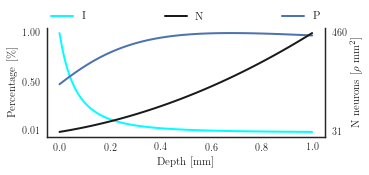

In [13]:
set_style('article')
fig, ax1 = plt.subplots()
r = np.arange(0,1.01,.01)

# neurons,_ = n_neurons(r, 'sum')
# mask = neurons <= 1000
# r = r[mask]

light = intensity(r)
neurons_cnt, rcorr = n_neurons(r, 'count')
photocurrent = Hill(10 * light)
prob =  photocurrent * neurons_cnt
prob /= prob.max()
ax2 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.15))

l, = ax1.plot(r, light, c='cyan', label='I')
n, = ax2.plot(r, neurons_cnt, 'k', label='N')
p, = ax1.plot(r, prob, label='P')

ax1.set_yticks([light.min().round(2), prob.min().round(1), light.max().round(1)])
ax2.set_yticks([neurons_cnt.min().round(), neurons_cnt.max().round()])

despine(right=False, top=True, ax=[ax1,ax2, ax3])
# ax2.set_ylim([neurons_cnt.min(), neurons_cnt.max()])
ax2.set_ylabel(r'N neurons [$\rho$ mm$^2$]')
ax1.set_ylabel(r'Percentage [\%]')
ax1.set_xlabel('Depth [mm]')
plt.legend(handles=[l,n,p], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
savefig(fig, 'opto-powerlaw')

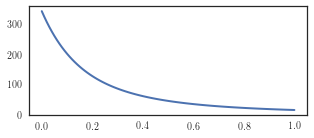

In [18]:
plt.plot(r,Hill(intensity(r)))

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1051: RuntimeWarning: divide by zero encountered in true_divide
  v2 = arc.vertices[::-1] * float(self.r - self.width) / self.r
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1051: RuntimeWarning: invalid value encountered in true_divide
  v2 = arc.vertices[::-1] * float(self.r - self.width) / self.r
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1061: RuntimeWarning: invalid value encountered in multiply
  v *= self.r


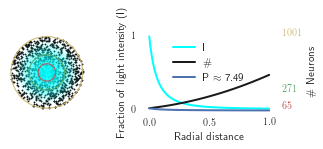

In [468]:
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection
set_style('article')

fig, (ax, ax1) = plt.subplots(1, 2)

size = 2.
x, y, cnt = [], [], 0
while cnt <= 1000:
    xx = np.random.uniform(-size*.5,size*.5,1)
    yy = np.random.uniform(-size*.5,size*.5,1)
    if np.sqrt(xx**2 + yy**2) < 1:
        x.append(xx)
        y.append(yy)
        cnt += 1
            
ax.scatter(x, y, color='k', s=2)
c_colors = ['r', 'g', 'y']
width = .01
radiuses = np.arange(0,1., width)
counts = []
for r, a in zip(radiuses, radiuses[::-1]):
    ax.add_patch(Wedge((0, 0), r, 0, 360, width=width, color='cyan', alpha=a**2))
for r, c in zip([.25,.5, 1.], c_colors):
    count = 0
    for xx, yy in zip(x,y):
        if np.sqrt(xx**2 + yy**2) < r:
            count += 1
    counts.append(count)
    ax.add_patch(Wedge((0, 0), r, 0, 360, width=0.02, color=c))
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False);
ax.set_aspect(1)


r = np.arange(0,1.01,.01)
light = intensity(r)
neurons = n_neurons(r)
prob = light * neurons

l, = ax1.plot(r, light, c='cyan', label='I')

ax2 = ax1.twinx()
n, = ax2.plot(r, neurons, 'k', label='\#')

p, = ax2.plot(r, prob, label='P $\\approx$ {:.2f}'.format(prob.mean()))

despine(right=True, top=True, left=True, bottom=True, xticks=True, ax=[ax, ax1,ax2])
ax1.set_yticks([0, 1])
ax2.set_yticks(counts)
ax2.set_ylabel('\# Neurons')
ax1.set_ylabel('Fraction of light intensity (I)')
ax1.set_xlabel('Radial distance')
# ax1.set_xticks([1,2,3,4])
plt.legend(handles=[l,n,p], loc=9)
# fix_figure(padLegend=.5, padHeight=.1)
plt.tight_layout()
for c, t in zip(c_colors, ax2.yaxis.get_ticklabels()):
    t.set_color(c)
savefig(fig, 'opto-powerlaw-comb')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1051: RuntimeWarning: divide by zero encountered in true_divide
  v2 = arc.vertices[::-1] * float(self.r - self.width) / self.r
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1051: RuntimeWarning: invalid value encountered in true_divide
  v2 = arc.vertices[::-1] * float(self.r - self.width) / self.r
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1061: RuntimeWarning: invalid value encountered in multiply
  v *= self.r


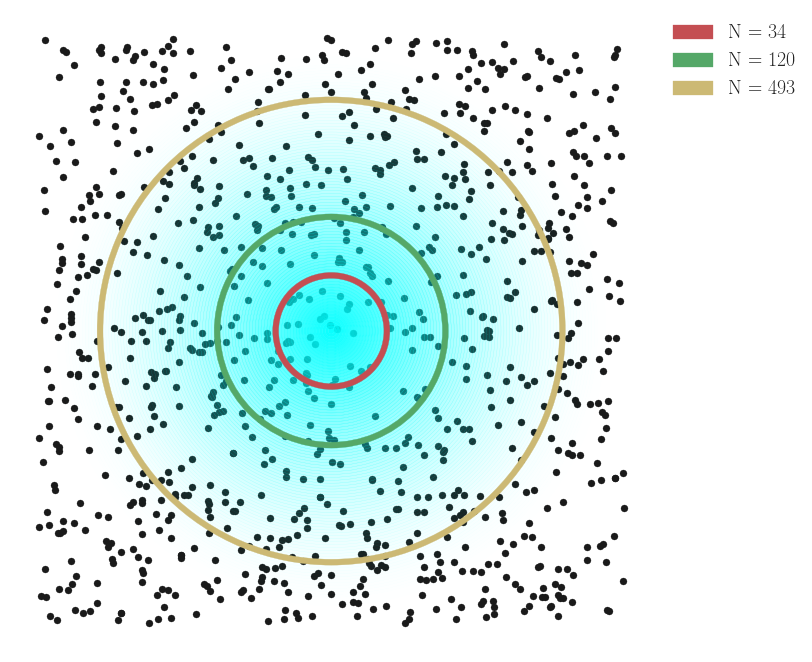

In [238]:
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection
fig, ax = plt.subplots(figsize=(9,9))
size = 2.
x = np.random.uniform(-size*.5,size*.5,1000)
y = np.random.uniform(-size*.5,size*.5,1000)
ax.scatter(x,y,color='k')

width = .01
radiuses = np.arange(0,1., width)

for r, a in zip(radiuses, radiuses[::-1]):
    ax.add_patch(Wedge((0, 0), r, 0, 360, width=width, color='cyan', alpha=a**2))
for r, c in zip([.2,.4, .8], ['r', 'g', 'y']):
    count = 0
    for xx, yy in zip(x,y):
        if np.sqrt(xx**2 + yy**2) < r:
            count += 1
    ax.add_patch(Wedge((0, 0), r, 0, 360, width=0.02, color=c, label='N = {}'.format(count)))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(bottom=True, left=True)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False);
fix_figure()
savefig(fig, 'network_stim')

In [15]:
a = list(range(10))

In [18]:
a

[2, 3, 4, 5, 6, 7, 8, 9]